# Logistic Regression with Kaggle Titanic data set

## Import packages and dataset

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

train = pd.read_csv('titanic_train.csv') # Training set is already available
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Check basic info about the data set including missing value

In [32]:
t=train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [34]:
d=train.describe()
d

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Exploratory analysis and plots

**Plot a bar diagram to check the number of numeric entries**

From the bar diagram, it shows that there are some age entries missing as the number of count for 'Age' is less than the other counts. We can do some impute/transformation of the data to fill-up the missing entries.

Text(0.5, 1.0, 'Count of numeric features')

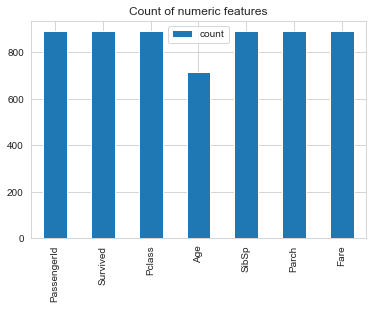

In [35]:
dT=d.T
dT.plot.bar(y='count')
plt.title("Count of numeric features")

**Check the relative size of survived and not-survived**

<AxesSubplot:xlabel='Survived', ylabel='count'>

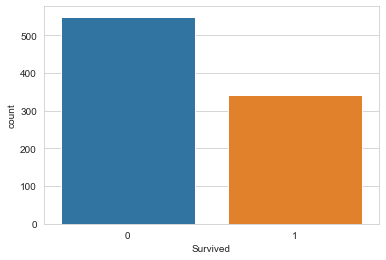

In [36]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train)

**Is there a pattern for the survivability based on sex?**

It looks like more female survived than males!

<AxesSubplot:xlabel='Survived', ylabel='count'>

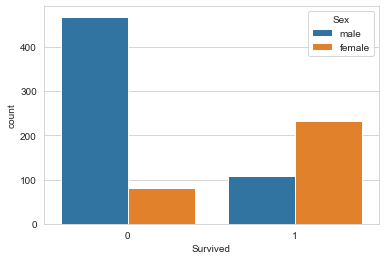

In [37]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train)

**What about any pattern related to passenger class?**

It looks like disproportionately large number of 3rd class passengers died!

<AxesSubplot:xlabel='Survived', ylabel='count'>

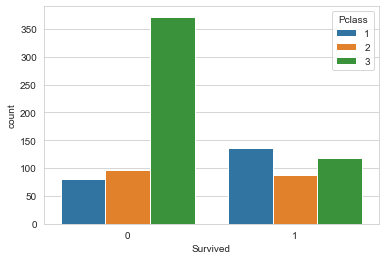

In [38]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train)

**Following code extracts and plots the fraction of passenger count that survived, by each class**

Text(0.5, 1.0, 'Fraction of passengers survived by class')

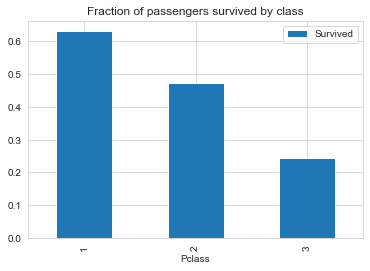

In [39]:
f_class_survived=train.groupby('Pclass')['Survived'].mean()
f_class_survived = pd.DataFrame(f_class_survived)
f_class_survived
f_class_survived.plot.bar(y='Survived')
plt.title("Fraction of passengers survived by class")

**What about any pattern related to having sibling and spouse?**

It looks like there is a weak trend that chance of survibility increased if there were more number of sibling or spouse

<AxesSubplot:xlabel='Survived', ylabel='count'>

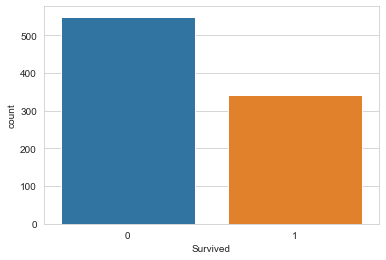

In [40]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train)

**How does the overall age distribution look like?**

<AxesSubplot:title={'center':'Age histogram of the passengers'}, xlabel='Age of the passengers', ylabel='Count'>

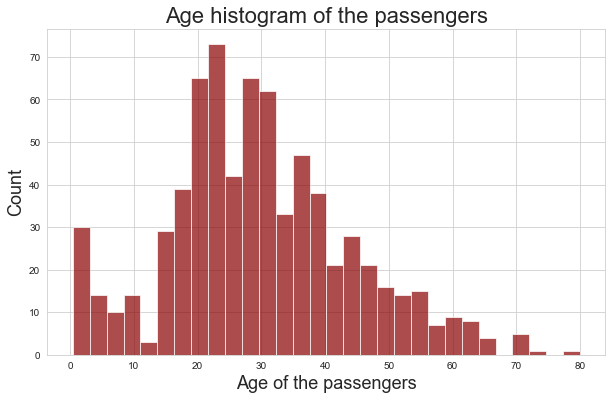

In [41]:
plt.xlabel("Age of the passengers",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Age histogram of the passengers",fontsize=22)
train['Age'].hist(bins=30,color='darkred',alpha=0.7,figsize=(10,6))

**How does the age distribution look like across passenger class?**

It looks like that the average age is different for three classes and it generally decreases from 1st class to 3rd class.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

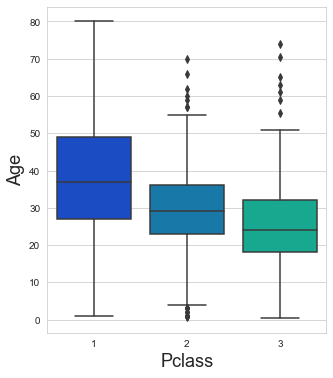

In [42]:
plt.figure(figsize=(5,6))
plt.xlabel("Passenger Class",fontsize=18)
plt.ylabel("Age",fontsize=18)
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Text(0.5, 0, 'Passenger class')

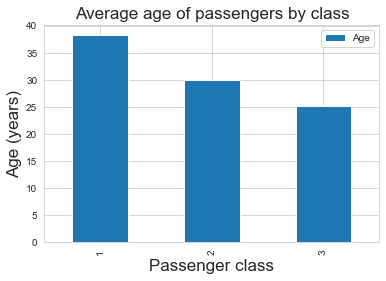

In [43]:
f_class_Age=train.groupby('Pclass')['Age'].mean()
f_class_Age = pd.DataFrame(f_class_Age)
f_class_Age.plot.bar(y='Age')
plt.title("Average age of passengers by class",fontsize=17)
plt.ylabel("Age (years)", fontsize=17)
plt.xlabel("Passenger class", fontsize=17)

## Data wrangling (impute and drop)
* Impute age (by averaging)
* Drop unncessary features
* Convert categorical features to dummy variables

### Define a function to impute (fill-up missing values) age feature

In [44]:
a=list(f_class_Age['Age'])

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return a[0]

        elif Pclass == 2:
            return a[1]

        else:
            return a[2]

    else:
        return Age

**Apply the above-defined function and plot the count of numeric features**

Text(0.5, 1.0, 'Bar plot of the count of numeric features')

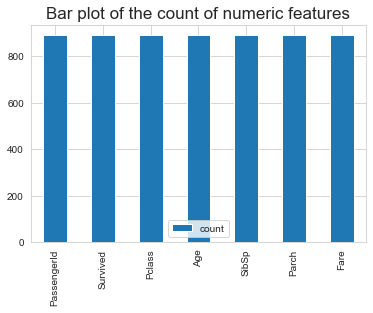

In [45]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
d=train.describe()
dT=d.T
dT.plot.bar(y='count')
plt.title("Bar plot of the count of numeric features",fontsize=17)

### Drop the 'Cabin' feature and any other null value

In [46]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Drop other unnecessary features like 'PassengerId', 'Name', 'Ticket'

In [47]:
train.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Convert categorial feature like 'Sex' and 'Embarked' to dummy variables

**Use pandas 'get_dummies()' function**

In [48]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [49]:
sex, embark

(     male
 0       1
 1       0
 2       0
 3       0
 4       1
 ..    ...
 886     1
 887     0
 888     0
 889     1
 890     1
 
 [889 rows x 1 columns],
      Q  S
 0    0  1
 1    0  0
 2    0  1
 3    0  1
 4    0  1
 ..  .. ..
 886  0  1
 887  0  1
 888  0  1
 889  0  0
 890  1  0
 
 [889 rows x 2 columns])

**Now drop the 'Sex' and 'Embarked' columns and concatenate the new dummy variables**

In [50]:
train.drop(['Sex','Embarked'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


This data set is now ready for logistic regression analysis!

## Logistic Regression model fit and prediction

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=111)

In [ ]:
## BUILD model and get confusion matrix 

In [52]:
# Fitting the Logistic Regression into the Training set

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\AdmiN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [53]:
# Predicting the test set results

Y_Pred = classifier.predict(X_test)

In [55]:
print([y_test],[Y_Pred])

[374    0
212    0
259    1
584    0
508    0
      ..
193    1
382    0
641    1
292    0
669    1
Name: Survived, Length: 267, dtype: int64] [array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0

In [56]:
# Making the Confusion Matrix 

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_Pred)
cm

array([[145,  18],
       [ 27,  77]], dtype=int64)